In [1]:
import os
import pandas as pd
import numpy as np
# from schrodinger import structure,structutils
# from schrodinger.structure import StructureReader, StructureWriter, SmilesStructure
# from schrodinger.structutils.transform import get_centroid
# from schrodinger.structutils import analyze,assignbondorders,rgroup_enumerate
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [4]:
dir_ = '/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/mu/'

In [164]:
# ====== 口袋提取 ======
from scipy.spatial import distance_matrix
from Bio.PDB import *
from Bio.PDB.PDBIO import Select
import os
import numpy as np
import pandas as pd
from rdkit import Chem


def extract(ligand, pdb):
    parser = PDBParser()
    if not os.path.exists(pdb) :
        print("The path of PDB is not available.")
        return None

    structure = parser.get_structure("protein", pdb)

    lp = []
    for l in ligand:
        lp.append(l.GetConformer().GetPositions())
    ligand_positions=np.concatenate(lp)

    class ResidueSelect(Select):
        def accept_residue(self, residue):
            residue_positions = np.array([np.array(list(atom.get_vector())) \
                for atom in residue.get_atoms() if "H" not in atom.get_id()])
            if len(residue_positions.shape) < 2:
                print(residue)
                return 0
            min_dis = np.min(distance_matrix(residue_positions, ligand_positions))
            if min_dis < 8.0:
                return 1
            else:
                return 0
    io = PDBIO()
    io.set_structure(structure)
    fn =  pdb.replace('protein.pdb', 'pocket.pdb')
    io.save(fn, ResidueSelect())  # 保存口袋


def pocket_extract(sdf_files, protein_file):

    ligands = []
    for a in sdf_files:
        mol = Chem.MolFromMolFile(a)
        if mol is not None:
            ligands.append(mol)
        else:
            print(f"{a} connot be read by rdkit!")

    extract(ligands,protein_file)


    print("The pocket has been extracted successfully.")

In [165]:
# d = dir_
# sdfs = [d+i for i in os.listdir(d) if i.endswith('.sdf')]
# for sdf in sdfs:
#     pocket_extract([sdf], sdf.replace('_ligand.sdf', '_protein.pdb'))


In [166]:
# ===== graph generation ======
from rdkit.Chem.rdchem import BondType as BT
import pickle
from rdkit import Chem
from rdkit.Chem import BRICS
import numpy as np
import pandas as pd
import torch
import os
import warnings
import multiprocessing
import dgl
from Bio.PDB.PDBParser import PDBParser

def setup_cpu(cpu_num):
    os.environ['OMP_NUM_THREADS'] = str(cpu_num)
    os.environ['OPENBLAS_NUM_THREADS'] = str(cpu_num)
    os.environ['MKL_NUM_THREADS'] = str(cpu_num)
    os.environ['VECLIB_MAXIMUM_THREADS'] = str(cpu_num)
    os.environ['NUMEXPR_NUM_THREADS'] = str(cpu_num)
    # torch.set_num_threads(cpu_num)

warnings.filterwarnings('ignore')


# 除了原子类型之外的一些原子特征，参考DynamicBind
allowable_features = {
    # 'possible_atomic_num_list': list(range(1, 119)) + ['misc'],
    'possible_chirality_list': ['CHI_UNSPECIFIED',
                                'CHI_TETRAHEDRAL_CW',
                                'CHI_TETRAHEDRAL_CCW',
                                'CHI_OTHER'],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_numring_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_implicit_valence_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list': ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring3_list': [False, True],
    'possible_is_in_ring4_list': [False, True],
    'possible_is_in_ring5_list': [False, True],
    'possible_is_in_ring6_list': [False, True],
    'possible_is_in_ring7_list': [False, True],
    'possible_is_in_ring8_list': [False, True]
    }

def safe_index(l, e):
    """ Return index of element e in list l. If e is not present, return the last index """
    try:
        return l.index(e)
    except:
        return len(l) - 1

# ====== for pockt group =======
one_to_three = {"A" : "ALA",
              "C" : "CYS",
              "D" : "ASP",
              "E" : "GLU",
              "F" : "PHE",
              "G" : "GLY",
              "H" : "HIS",
              "I" : "ILE",
              "K" : "LYS",
              "L" : "LEU",
              "M" : "MET",
              "N" : "ASN",
              "P" : "PRO",
              "Q" : "GLN",
              "R" : "ARG",
              "S" : "SER",
              "T" : "THR",
              "V" : "VAL",
              "W" : "TRP",
              "Y" : "TYR",
              "B" : "ASX",
              "Z" : "GLX",
              "X" : "UNK",
              "*" : " * "}

three_to_one = {}
for _key, _value in one_to_three.items():
    three_to_one[_value] = _key
three_to_one["SEC"] = "C"
three_to_one["MSE"] = "M"

pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                 'X']
pro_res_aliphatic_table = ['A', 'I', 'L', 'M', 'V']
pro_res_aromatic_table = ['F', 'W', 'Y']
pro_res_polar_neutral_table = ['C', 'N', 'Q', 'S', 'T']
pro_res_acidic_charged_table = ['D', 'E']
pro_res_basic_charged_table = ['H', 'K', 'R']

def prop(residue):
    res_property1 = [1 if residue in pro_res_aliphatic_table else 0, 1 if residue in pro_res_aromatic_table else 0,
                        1 if residue in pro_res_polar_neutral_table else 0,
                        1 if residue in pro_res_acidic_charged_table else 0,
                        1 if residue in pro_res_basic_charged_table else 0, 1]
    return res_property1

def res_pocket(p):

    parser = PDBParser(PERMISSIVE=1)
    s = parser.get_structure('a', p)
   
    atom2res_idx = []  # 残基index  原子id到残基id的索引， 重新排序的残基index，相当于atom在第几个group
    res_name = []
    count = -1
    for model in s:
        for chain in model:
            for residue in chain:
                count += 1
                name = residue.get_resname()
                for atom in residue:
                    if atom.get_fullname() [0] != 'H' and atom.get_fullname()[1] != 'H':
                        atom2res_idx.append(count)
                        res_name.append(name)

    res3 = [three_to_one[i] if i in three_to_one.keys() else 'X' for i in res_name]

    res_type = [pro_res_table.index(i) for i in res3]  # 每个原子对应的氨基酸残基类型
    res_prop  = [prop(i) for i in res3]  # 每个原子对应的氨基酸残基性质
    assert len(atom2res_idx) == len(res_type) == len(res_prop)
    return atom2res_idx, res_type, res_prop


def lig_atom_featurizer(mol):
    ringinfo = mol.GetRingInfo()
    atom_features_list = []
    for idx, atom in enumerate(mol.GetAtoms()):
        atom_features_list.append([
            safe_index(allowable_features['possible_chirality_list'], str(atom.GetChiralTag())),
            safe_index(allowable_features['possible_degree_list'], atom.GetTotalDegree()),
            safe_index(allowable_features['possible_formal_charge_list'], atom.GetFormalCharge()),
            safe_index(allowable_features['possible_numH_list'], atom.GetTotalNumHs()),
            safe_index(allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
            allowable_features['possible_is_aromatic_list'].index(atom.GetIsAromatic()),
            safe_index(allowable_features['possible_implicit_valence_list'], atom.GetImplicitValence()),
            safe_index(allowable_features['possible_number_radical_e_list'], atom.GetNumRadicalElectrons()),
            safe_index(allowable_features['possible_numring_list'], ringinfo.NumAtomRings(idx)),
            allowable_features['possible_is_in_ring3_list'].index(ringinfo.IsAtomInRingOfSize(idx, 3)),
            allowable_features['possible_is_in_ring4_list'].index(ringinfo.IsAtomInRingOfSize(idx, 4)),
            allowable_features['possible_is_in_ring5_list'].index(ringinfo.IsAtomInRingOfSize(idx, 5)),
            allowable_features['possible_is_in_ring6_list'].index(ringinfo.IsAtomInRingOfSize(idx, 6)),
            allowable_features['possible_is_in_ring7_list'].index(ringinfo.IsAtomInRingOfSize(idx, 7)),
            allowable_features['possible_is_in_ring8_list'].index(ringinfo.IsAtomInRingOfSize(idx, 8)),
        ])

    return atom_features_list


def group_complex(ligand, pocket_dir):
    brics_index = brics_decomp(ligand)
    group_index = [0 for _ in range(len(ligand.GetAtoms()))]
    group_type = [0 for _ in range(len(ligand.GetAtoms()))]   # 全为0
    group_prop = [[0,0,0,0,0,0] for _ in range(len(ligand.GetAtoms()))] # 全为0

    if type(brics_index) == type(tuple(('a', 'b', 'c'))):
        brics_index = brics_index[0]

    for i, idx in enumerate(brics_index):
        for idx_ in idx:
            group_index[idx_] = i

    atom2res_idx, res_type, res_prop = res_pocket(pocket_dir)

    atom2res_idx = [i+len(brics_index) for i in atom2res_idx] # 前面的几个index给小分子
    res_type = [i+1 for i in res_type] # 0给小分子group

    group_index.extend(atom2res_idx)
    group_type.extend(res_type)
    group_prop.extend(res_prop)

    return torch.tensor(group_index,dtype=torch.float32), torch.tensor(group_type,dtype=torch.float32), torch.tensor(group_prop, dtype=torch.float32)


def atom_type(ligand,pocket):
    # ====== 获得原子类型 ======
    l_atom = np.array([i.GetAtomicNum() for i in ligand.GetAtoms()])
    lig_atom = [1 for _ in l_atom]
    p_atom = np.array([i.GetAtomicNum() for i in pocket.GetAtoms()])
    pock_atom = [0 for _ in p_atom]
    complex_atom = torch.tensor(np.concatenate([l_atom, p_atom]))
    type_for_mask = torch.tensor(np.concatenate([lig_atom, pock_atom]))
    z = complex_atom
    return z, type_for_mask


# ========= 获得原子类型作为边的标量信息 ===========
bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3} # 4:分子内部边; 5:蛋白内部边; 6:蛋白-配体边

def bond_featurizer(ligand, pocket, index):
    bond_type = []
    num_atoms = len(ligand.GetAtoms())
    for a1, a2 in zip(index[0], index[1]):
        if a1 < num_atoms and a2 < num_atoms:   # 配体内部
            bond = ligand.GetBondBetweenAtoms(a1, a2)
            if bond is None:
                bond_type.append(4)   # distance bond
            else:
                bond_type.append(bonds[bond.GetBondType()])
        elif a1 >= num_atoms and a2 >= num_atoms: # 蛋白内部
            a1 = a1 - num_atoms
            a2 = a2 - num_atoms
            bond = pocket.GetBondBetweenAtoms(a1, a2)
            if bond is None:
                bond_type.append(5)   # distance bond
            else:
                bond_type.append(bonds[bond.GetBondType()])
        else:
            bond_type.append(6)
    return torch.tensor(bond_type, dtype=torch.float32)
    

# ===== mol split =====
def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques


def Graph_Information(ligand_file, pocket_file):

    ligand = Chem.MolFromMolFile(ligand_file)
    ligand = Chem.RemoveAllHs(ligand)
    pocket = Chem.MolFromPDBFile(pocket_file)
    pocket = Chem.RemoveAllHs(pocket)


    graph_data = {
                ('atom', 'int', 'atom'): ([], []),
                ('atom', 'ind', 'atom'): ([], [])

                }
    G = dgl.heterograph(graph_data)

    # ====== 获得原子类型及来源信息 =======
    x, type_for_mask = atom_type(ligand, pocket)
    G.add_nodes(x.shape[0])
    
    # ====== 获得其余原子标量信息 =======
    lig_atom_feature = lig_atom_featurizer(ligand)
    pock_atom_feature = lig_atom_featurizer(pocket)
    atom_scalar = torch.tensor(np.concatenate([lig_atom_feature, pock_atom_feature]), dtype=torch.float32)

    # ===== 基于group的信息 =====
    index, g_type, g_prop = group_complex(ligand, pocket_file)

    # ====== 获得原子坐标 ======
    coor_lig = ligand.GetConformer().GetPositions()
    coor_pock = pocket.GetConformer().GetPositions()
    pos = np.concatenate([coor_lig, coor_pock])
    pos = torch.tensor(pos, dtype=torch.float32)
    G.nodes['atom'].data['pos'] = pos
    
    # ====== type1: 小分子内部边 ======  
    # (ind = independent)
    for i in range(len(coor_lig)):
        for j in range(i + 1, len(coor_lig)):
            dist = np.linalg.norm(coor_lig[i] - coor_lig[j])
            if dist <= 5 and dist > 0:
                # # G.add_edges(i, j, etype='ind')
                # # G.add_edges(j, i, etype='ind')
                G.add_edges(i, j, etype='int')
                G.add_edges(j, i, etype='int')
                continue

    # ====== type2: 蛋白口袋共价边 ======  
    # (ind = independent)
    for bond in pocket.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        # G.add_edges(start_atom + len(coor_lig), end_atom + len(coor_lig), etype='ind')
        # G.add_edges(end_atom + len(coor_lig), start_atom + len(coor_lig), etype='ind')
        G.add_edges(start_atom + len(coor_lig), end_atom + len(coor_lig), etype='int')
        G.add_edges(end_atom + len(coor_lig), start_atom + len(coor_lig), etype='int')
        continue


    # ====== type3: 蛋白和小分子的距离边 ======  
    # (int = interaction)
    for i in range(len(coor_lig)):
        for j in range(len(coor_pock)):
            dist = np.linalg.norm(coor_lig[i] - coor_pock[j])
            if dist <= 5 and dist > 0:
                G.add_edges(i, len(coor_lig) + j, etype='int')
                G.add_edges(len(coor_lig) + j, i, etype='int')
                continue
    
    # ====== type4: 蛋白靠近表面的原子与其余蛋白原子的距离边 ======  
    # (int = interaction)
    # 找到所有与小分子连接的蛋白质原子
    connected_protein_atoms = set(j for i in range(len(coor_lig)) for j in G.successors(i,etype='int') if j >= len(coor_lig))
    # print(connected_protein_atoms)
    for i in connected_protein_atoms:
        for j in range(len(coor_pock)):
            dist = np.linalg.norm(coor_pock[i - len(coor_lig)] - coor_pock[j])
            # print(G.has_edges_between(i, len(coor_lig) + j, etype='ind').item())
            if  (dist <= 3) and (dist > 0) and  (G.has_edges_between(i, len(coor_lig) + j, etype='ind').item() is False):
                # G.add_edges(i, len(coor_lig) + j, etype='ind')
                # G.add_edges(len(coor_lig) + j, i, etype='ind')
                G.add_edges(i, len(coor_lig) + j, etype='int')
                G.add_edges(len(coor_lig) + j, i, etype='int')
                continue

    edge_index_int = [G.edges(etype='int')[0].detach().numpy().tolist(), G.edges(etype='int')[1].detach().numpy().tolist()]
    edge_index_ind = [G.edges(etype='ind')[0].detach().numpy().tolist(), G.edges(etype='ind')[1].detach().numpy().tolist()]

    # ====== 获得边的标量信息(边类型) ========
    bond_type_int = bond_featurizer(ligand, pocket, edge_index_int)
    bond_type_ind = bond_featurizer(ligand, pocket, edge_index_ind)
    
    # ====== 其中x是原子类型， atom_scalar是除了原子类型之外的原子信息 ========
    #index, g_type, g_prop
    G.nodes['atom'].data['res_idx'] = index
    G.nodes['atom'].data['res_type'] = g_type
    G.nodes['atom'].data['res_prop'] = g_prop

    G.nodes['atom'].data['x'] = x
    G.nodes['atom'].data['pos'] = pos
    G.nodes['atom'].data['type'] =type_for_mask
    G.nodes['atom'].data['atom_scalar'] = atom_scalar
    G.edges['ind'].data['bond_scalar'] = bond_type_ind
    G.edges['int'].data['bond_scalar'] = bond_type_int
    return G


def graph_save(ligand_file, pock_file, pickle_save):
    
    if not (os.path.exists(ligand_file) and os.path.exists(pock_file)):
        return None

    data = Graph_Information(ligand_file, pock_file)
    pickle_save = open(pickle_save, 'wb')
    pickle.dump(data, pickle_save)
    pickle_save.close()

In [3]:
dir_ = '/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/mu/'

In [168]:
data_list = []

d = dir_
sdfs = [d+i for i in os.listdir(d) if i.endswith('.sdf')]
for sdf in sdfs:
    data_list.append([sdf, sdf.replace('_ligand.sdf', '_pocket.pdb'), sdf.replace('.sdf', '.pkl')])

# for ligand_file, pock_file, pickle_save in data_list:
#     graph_save(ligand_file, pock_file, pickle_save)
import multiprocessing

def print_error(value):
    print("error: ", value)
    
pool = multiprocessing.Pool(50)
for i in data_list:
    pool.apply_async(graph_save, i, error_callback=print_error)
pool.close()
pool.join()

In [ ]:
# ===== input file generation =======

from rdkit import Chem
from rdkit import DataStructs

def input_G(d, dir_):
    lab = []
    all = []
    for n, ic in d.items():
        all.append(dir_ + '/' + n + '.pkl')
        lab.append(ic)

        

    WT = "/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/geo/B1.pkl"

    N1 = []
    N2 = []
    L1 = []
    L2 = []
    L = []
    D1 = []
    D2 = []
    system = []

    data_list =[]

    for i, pkl in enumerate(all):
        l = lab[i]

        N1.append(WT.split('/')[-1])
        D1.append(WT)
        N2.append(pkl.split('/')[-1])
        D2.append(pkl)
        L.append(l)

    data_list.append(pd.DataFrame({
                'lig1' : N1,
                'lig2' : N2,
                'Label' : L,
                'Label1' : L,
                'Label2' : L,
                'dir_1':D1,
                'dir_2':D2
            }))

    pd.concat(data_list).to_csv(dir_ + '/predict.csv',index = 0)

In [177]:
names = [i.split('.')[0] for i in os.listdir(dir_) if i.endswith('.pkl') and not i.startswith('WT')]
ic50 = [0 for i in names]


names

d = dict()
for n,ic in zip(names, ic50):
    try:
        ic = float(ic)
    except:
        continue
    
    # ic = -np.log10(ic*1e-6)
    d[n] = ic
# d
input_G(d, dir_)

In [171]:
# ========= predict =========

from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import dgl

import sys
sys.path.append("/home/user-home/yujie/0_PBCNetv2/AIcode_tensornet/")
from Dataloader.dataloader import LeadOptDataset
from utilis.utilis import  pkl_load


import dgl

class LeadOptDataset():
    def __init__(self, df_path, label_scalar=None):
        self.df_path = df_path
        self.df = pd.read_csv(self.df_path)
        self.label_scalar = label_scalar

        if self.label_scalar == "finetune":
            label = self.df.Lable.values
            label = (np.array(label).astype(float) - 0.04191832) / 1.34086546
            self.df["Lable"] = label

        elif self.label_scalar is not None:
            label = self.df.Lable.values
            label = np.reshape(label, (-1, 1))
            self.label_scalar = self.label_scalar.fit(label)
            label = self.label_scalar.transform(label)
            self.df["Lable"] = label.flatten()

        self.df = self.df
        super(LeadOptDataset, self).__init__()

            
    def file_names_(self):
        ligand_dir = self.df.Ligand1.values
        file_names = [s.rsplit("/", 2)[1] for s in ligand_dir]
        return list(set(file_names))

        
    def __getitem__(self, idx):
        return self.df[idx:idx + 1]

    def __len__(self):
        return len(self.df)


def collate_fn_acs(samples):
    ligand1_dir = [s.dir_1.values[0] for s in samples]
    ligand2_dir = [s.dir_2.values[0] for s in samples]

    graph1_list = [pkl_load(s) for s in ligand1_dir]
    graph2_list = [pkl_load(s) for s in ligand2_dir]
    
    g1 = dgl.batch(graph1_list)
    g2 = dgl.batch(graph2_list)

    label_list = [s.Label.values[0] for s in samples]  # delta
    label1_list = [s.Label1.values[0] for s in samples]  # validation samples' labels
    label2_list = [s.Label2.values[0] for s in samples]  # referance train samples' labels

    return g1, \
           g2, \
           torch.tensor(label_list, dtype=torch.float32), \
           torch.tensor(label1_list, dtype=torch.float32), \
           torch.tensor(label2_list, dtype=torch.float32 ), \
           None, \
           None


# def com_mean(a,idx):
#     return np.mean(np.array(a)[idx])


@torch.no_grad()
def predict(model, loader, device):
    # 用于预测的模块，model：训练好的模型，loader：Test data loader， device
    model.eval()

    valid_prediction = []
    valid_labels = []
    ref_1_labels = []  # 第一个分子是参照分子
    valid_2_labels = []  # 第二个分子是待测分子


    att__1 = []
    att__2 = []

    for batch_data in loader:
        graph1, graph2, label, label1, label2, rank1, file_name = batch_data
        # to cuda
        graph1, graph2,  label, label1, label2 = (graph1.to(device), graph2.to(device), label.to(device), label1.to(
            device), label2.to(device))

        logits,_ = model(graph1,
                       graph2)

        valid_prediction += logits.tolist()


        valid_labels += label.tolist()
        ref_1_labels += label1.tolist()
        valid_2_labels += label2.tolist()


    mae = mean_absolute_error(valid_labels, valid_prediction)
    rmse = mean_squared_error(valid_labels, valid_prediction) ** 0.5

    # ======== to 'kcal/mol' unit =======
    valid_labels_G = np.log(np.power(10, -np.array(valid_labels).astype(float)))*297*1.9872*1e-3
    valid_prediction_G = np.log(np.power(10, -np.array(valid_prediction).astype(float)))*297*1.9872*1e-3

    mae_g = mean_absolute_error(valid_labels_G, valid_prediction_G)
    rmse_g = mean_squared_error(valid_labels_G, valid_prediction_G) ** 0.5

    valid_prediction = np.array(valid_prediction).flatten()
    valid_prediction_G = np.array(valid_prediction_G).flatten()

    return mae, rmse, mae_g, rmse_g, valid_prediction, valid_prediction_G,np.array(valid_labels),np.array(ref_1_labels),np.array(valid_2_labels)

In [ ]:
def test_acs(logger_writer,model,device,code_path,batch_size):

    rmse_gs = []
    # load the test data (测试数据加载)

    df_file = pd.read_csv(dir_ + "/predict.csv")

    test_dataset = LeadOptDataset(dir_ + "/predict.csv")

    test_dataloader = DataLoader(test_dataset,
                                 collate_fn=collate_fn_acs,
                                 batch_size=batch_size,
                                 drop_last=False,
                                 shuffle=False,
                                 pin_memory=False)

    mae,rmse,mae_g,rmse_g,valid_prediction,valid_prediction_G,valid_labels,ref_1_label,val_2_label= predict(model, test_dataloader, device)
        
    return valid_prediction

model = torch.load("/home/user-home/yujie/0_PBCNetv2/results/TN/results_20240918_s+c_seed1_tensornet_5bond_nobbnorm_p-p_可用63000/Bind_a2a_device1_hidden96_foldmse_lr1e-6_862w_attwithatom_seed1/model_0_63000_1.pth",
map_location=torch.device('cpu'),weights_only=False)

pre = test_acs(None,model,'cpu',None,8)

In [179]:
pre

array([-0.74751145, -0.23684525, -0.22667795,  0.12946928, -0.09406538,
       -0.18855594, -0.72143024, -1.44648874, -0.34084415, -0.18556918,
       -0.20364618, -0.52624959,  0.0028414 , -0.38893485, -0.25133577,
       -0.15314251, -0.67465383, -0.26951364, -0.49079198, -0.27518883,
        0.22654845, -0.1124431 , -0.17383972, -0.20492649, -0.80107057,
       -0.41872489, -0.20672175, -0.36660558, -0.33922863,  0.26444238,
       -0.32182854, -0.24369738, -0.69567585, -0.1429432 , -0.01192364,
       -0.28257352, -0.32927746, -0.39459348, -0.31604308,  0.4707194 ,
       -0.34951353, -0.16942739, -0.47025174])

In [5]:
import pandas as pd
df_file = pd.read_csv(dir_ + "/predict1.csv")
# df_file['pre'] = pre
# df_file.to_csv(dir_ + "/predict1.csv",index=0)

In [6]:
res = df_file.sort_values(by='pre', ascending=True).reset_index()
a = pd.DataFrame(res, columns = ['lig1','pre'])
a

,lig1,pre
0,protein_296_ligand.pkl,-1.446489
1,protein_457_ligand.pkl,-0.801071
2,protein_477_ligand.pkl,-0.747511
3,protein_458_ligand.pkl,-0.721430
4,protein_170_ligand.pkl,-0.695676
5,protein_124_ligand.pkl,-0.674654
6,protein_452_ligand.pkl,-0.526250
7,protein_427_ligand.pkl,-0.490792
8,protein_121_ligand.pkl,-0.470252
9,protein_125_ligand.pkl,-0.418725


In [7]:
[int(i.split('_')[1]) for i in a.lig1.values]

[296,
 457,
 477,
 458,
 170,
 124,
 452,
 427,
 121,
 125,
 456,
 112,
 127,
 302,
 465,
 122,
 297,
 167,
 301,
 171,
 169,
 177,
 172,
 268,
 292,
 455,
 289,
 461,
 401,
 450,
 116,
 117,
 300,
 106,
 244,
 120,
 123,
 460,
 173,
 463,
 459,
 174,
 303]

In [8]:
res = ['PHE 296',
 'ASN 457',
 'LEU 477',
 'ILE 458',
 'PHE 170',
 'GLU 124',
 'TRP 452',
 'LEU 427',
 'ASP 121',
 'VAL 125',
 'TYR 456',
 'LYS 112',
 'LYS 127',
 'CYS 302',
 'PHE 465',
 'LEU 122',
 'ASN 297',
 'PRO 167',
 'CYS 301',
 'PRO 171',
 'ASN 169',
 'TRP 177',
 'LEU 172',
 'GLU 268',
 'GLU 292',
 'THR 455',
 'GLN 289',
 'CYS 461',
 'PHE 401',
 'THR 450',
 'GLU 116',
 'SER 117',
 'GLN 300',
 'GLU 106',
 'THR 244',
 'LEU 120',
 'ASP 123',
 'THR 460',
 'VAL 173',
 'THR 463',
 'VAL 459',
 'MET 174',
 'CYS 303']
 
v = -a.pre.values

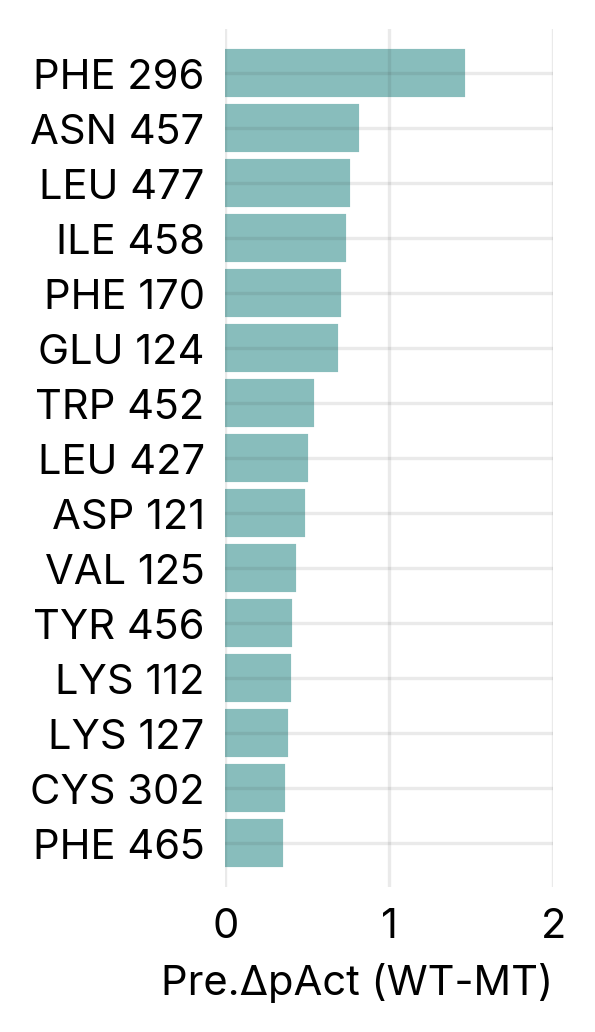

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import to_rgba
import cmasher as cmr
import morethemes as mt
mt.set_theme("minimal")

cm = 1/2.54
fontsize = 10
# 生成热图


# ================================== delta值========================================
def plt_scatter(x,y):
    
    fig, axs = plt.subplots(1,1,figsize=(5.3*cm,9*cm))
    fig.dpi=300

    # bars = axs.barh( x,y)     #steelblue #B6CADA
    xxx='#88bdbc'
    bars = axs.barh( x,y, color=to_rgba(xxx, alpha=1),edgecolor=xxx)     #steelblue #B6CADA

    axs.tick_params(labelsize=fontsize)

    # axs.set_ylabel("Spearman", fontsize=22)
    axs.set_xlabel("Pre.ΔpAct (WT-MT)", fontsize=fontsize)

    # axs.set_ylim(-0.8,19.8)
    axs.set_ylim(-0.8,14.8)
    axs.set_xlim(0,2)





    plt.tight_layout()
    # plt.show()
    plt.savefig(f'/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/mu/排序能力_15.svg', bbox_inches='tight',dpi=1000)

plt_scatter(res[::-1][-15:],v[::-1][-15:])

In [244]:
mmgbsa = pd.read_csv("/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/mu/residue_scanning_2-results.csv").sort_values(by='delta Affinity', ascending=False).reset_index()
res =  [i.split('(')[1][0:3]+' '+i.split('(')[0][-3:] for i in mmgbsa.Mutations.values]
v = mmgbsa['delta Affinity'].values

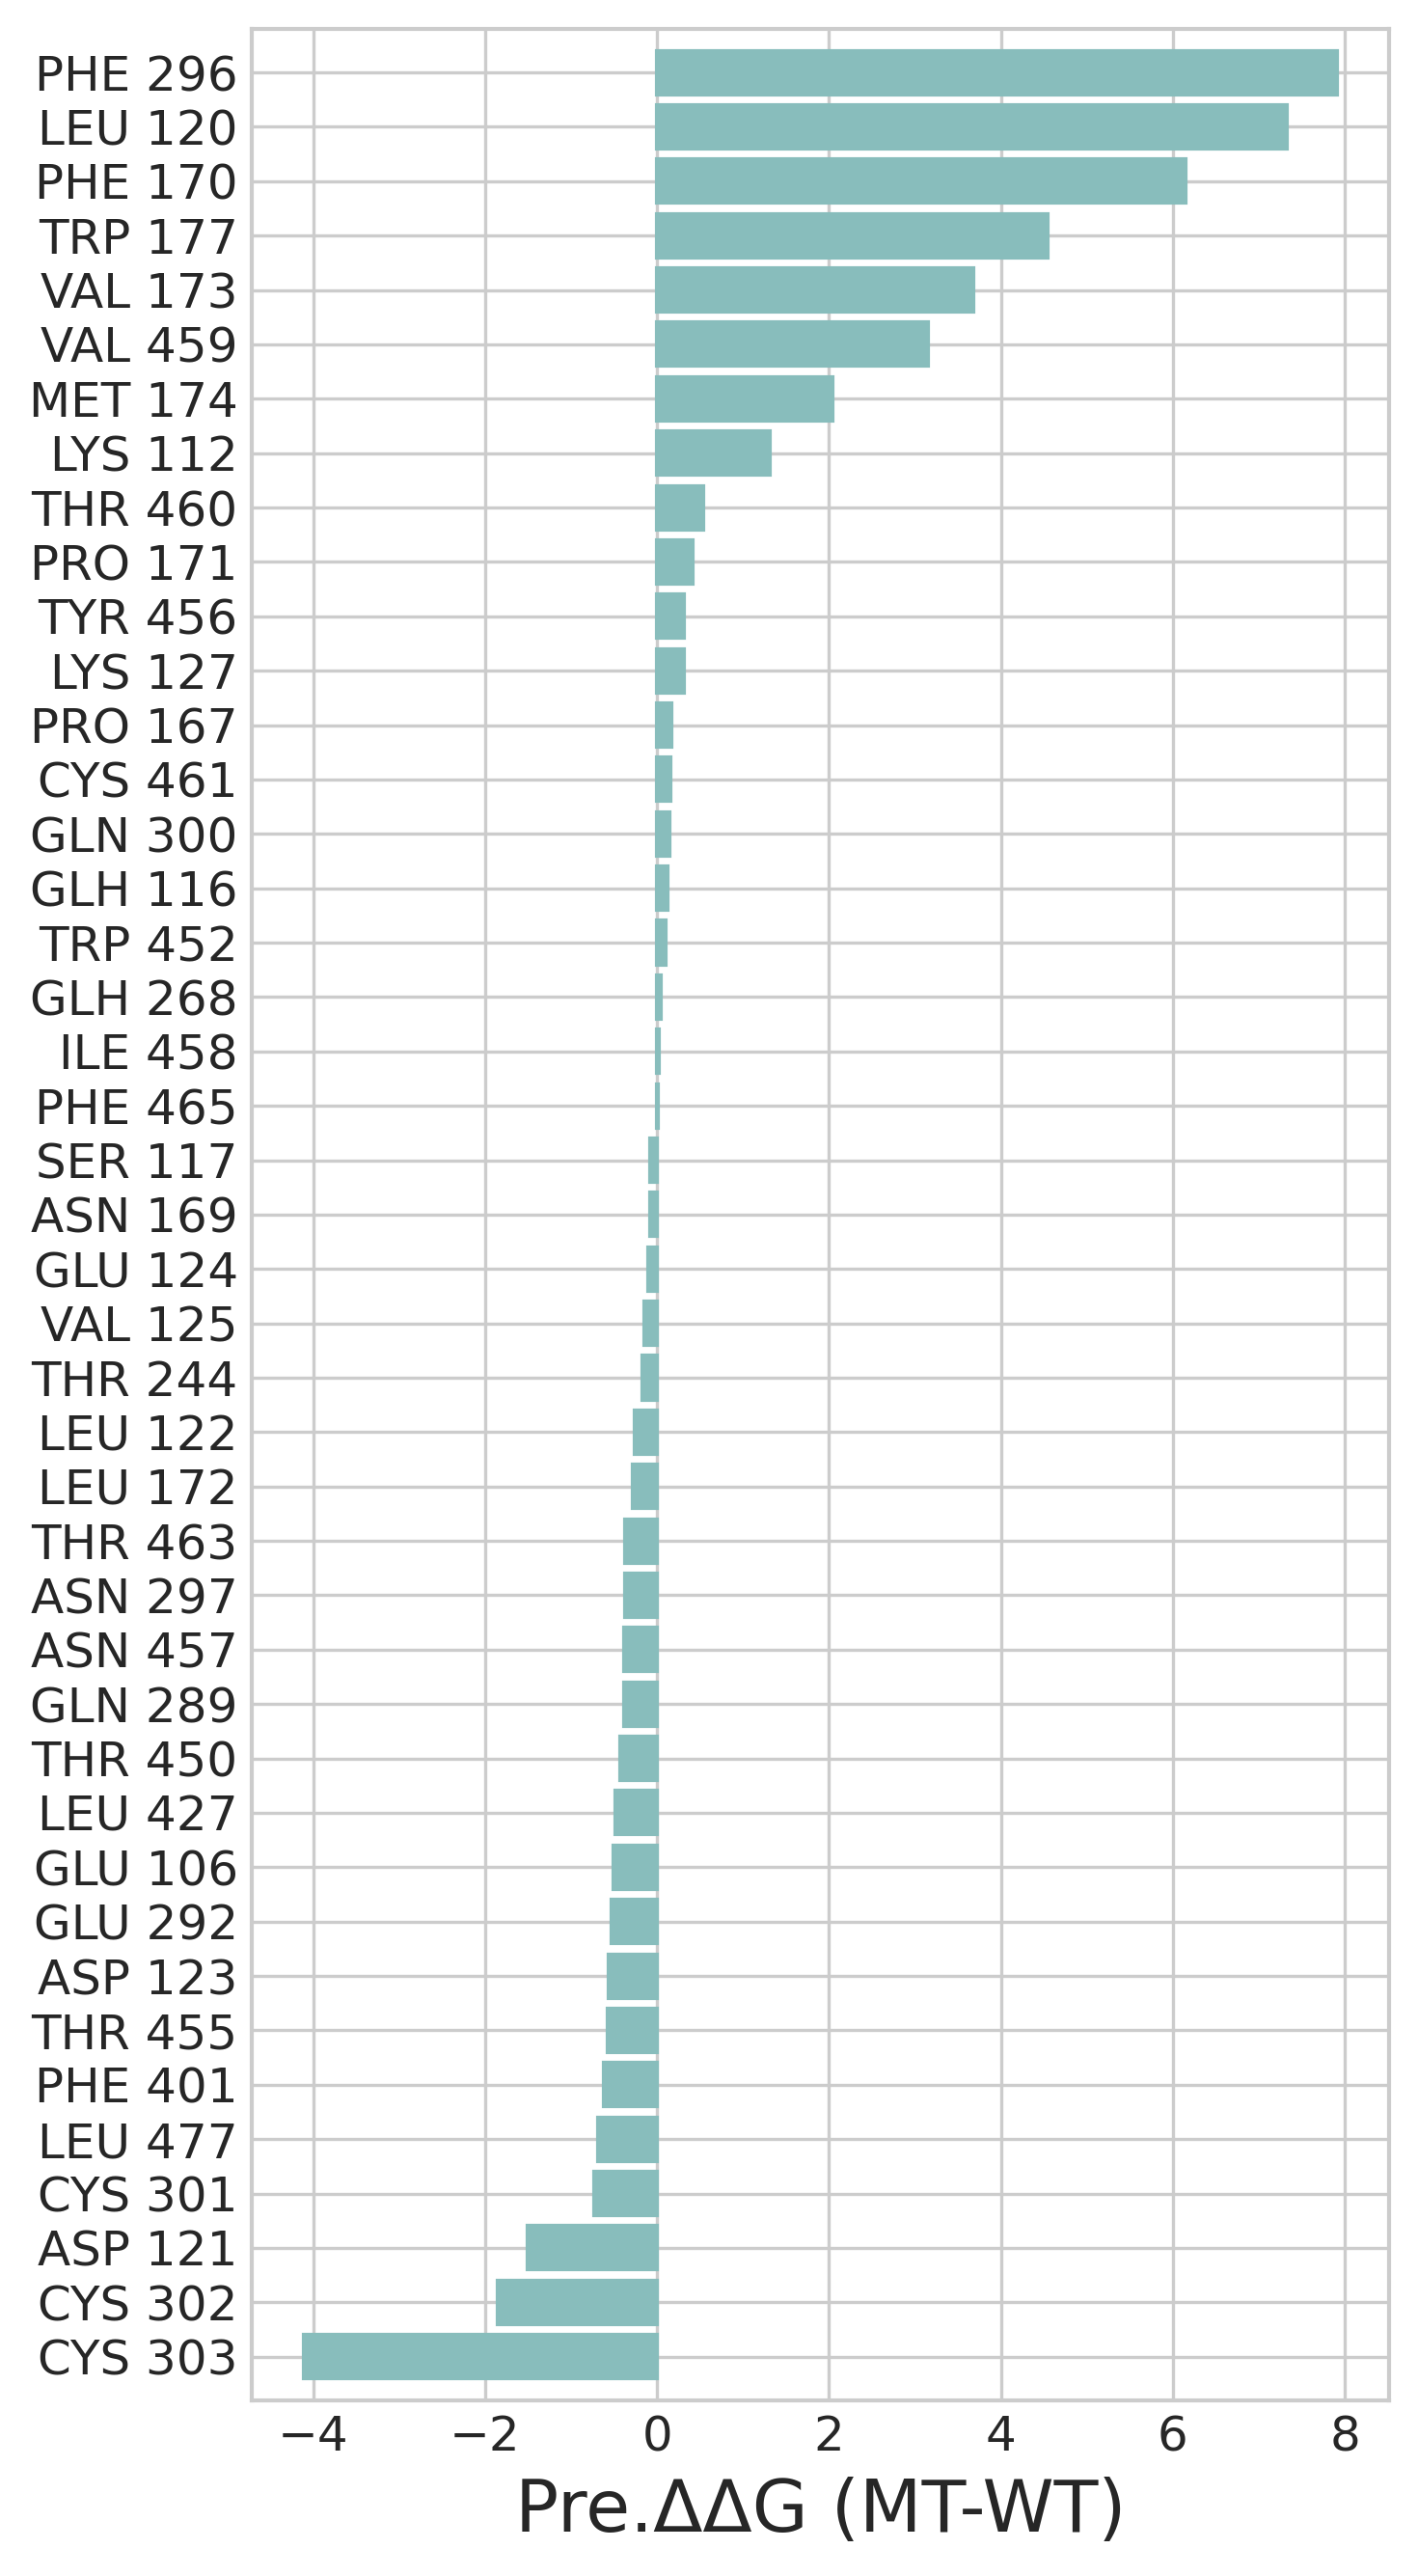

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statannotations.Annotator import Annotator
from matplotlib.colors import to_rgba


# ================================== delta值========================================
def plt_scatter(x,y):
    
    fig, axs = plt.subplots(1,1,figsize=(5,9))
    fig.dpi=300

    # bars = axs.barh( x,y)     #steelblue #B6CADA
    xxx='#88bdbc'
    bars = axs.barh( x,y, color=to_rgba(xxx, alpha=1),edgecolor=xxx)     #steelblue #B6CADA

    # for bar in bars:
    #     yval = bar.get_width()
    #     axs.text(bar.get_x() + bar.get_width()/2, yval+0.01, yval, ha='center', va='bottom',fontsize=16)


    axs.tick_params(labelsize=12)

    # axs.set_ylabel("Spearman", fontsize=22)
    axs.set_xlabel("Pre.ΔΔG (MT-WT)", fontsize=18)

    axs.set_ylim(-0.8,42.8)
    # axs.set_xlim(-0.5,10.5)
    # axs.set_xticks([0,1,2,3,4,5,6,7,8,9,10],
    #                ['Glide SP', 'MM-GB/SA','PSICHIC','BIND','Plapt','PIGNet2.0','RTMScore','GenScore','Onionnet2.0','PBCNet','PBCNet2.0'],
    #                fontsize=16,
    #                rotation=30)

    # # axs.set_title('Ranking Ability (Spearman) of Models on FEP Sets',fontsize=22)
    # # axs.spines["top"].set_visible(False)    # 隐藏上边框
    # # axs.spines["right"].set_visible(False) # 隐藏右边框


    plt.tight_layout()
    plt.style.use('seaborn-v0_8-whitegrid')
    # plt.show()
    plt.savefig(f'/home/user-home/yujie/0_PBCNetv2/data_BindingDB/1B1/mu/mmgbsa_all.svg', bbox_inches='tight',dpi=1000)

plt_scatter(res[::-1],v[::-1])

In [174]:
import pandas as pd
df_file = pd.read_csv(dir_ + "/predict.csv")
df_file['pre'] = pre
df_file.to_csv(dir_ + "/predict.csv",index=0)

In [175]:
res = df_file.sort_values(by='pre', ascending=False).reset_index()
pd.DataFrame(res, columns = ['lig2','pre'])

,lig2,pre
0,protein_296_ligand.pkl,1.080654
1,protein_457_ligand.pkl,0.750936
2,protein_170_ligand.pkl,0.668976
3,protein_458_ligand.pkl,0.668264
4,protein_124_ligand.pkl,0.638172
5,protein_477_ligand.pkl,0.622155
6,protein_452_ligand.pkl,0.409685
7,protein_427_ligand.pkl,0.355705
8,protein_121_ligand.pkl,0.331517
9,protein_456_ligand.pkl,0.294196
